# Deep Neural Net for Sentiment Classification

This Deep Net performs sentiment analysis on the IMDB review dataset.

In [1]:
import os

import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import sklearn.metrics
from sklearn.metrics import roc_auc_score

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set Hyperparameters

In [2]:
output_dir = 'model_output/dense'

epochs = 3
batch_size = 64
patience = 10
val_split = .3

n_dim = 128
n_unique_words = 10000
max_review_length = 200
pad_type = trunc_type = 'pre'

n_dense = 64
dropout = .5

#### Load Data

In [3]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

In [4]:
# X_valid[0]

In [5]:
for x in X_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [6]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

In [7]:
len(X_train), len(y_train)

(25000, 25000)

#### Restore Words from index

In [8]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k : (v+3) for k,v in word_index.items()}
word_index['PAD'] = 0
word_index['START'] = 1
word_index['UNK'] = 2

In [9]:
# word_index

In [10]:
index_word = {v:k for k,v in word_index.items()}

In [11]:
# index_word

In [12]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [13]:
' '.join(index_word[id] for id in X_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little boy's that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have d

In [14]:
(all_X_train, _), (all_X_valid, _) = imdb.load_data()

In [15]:
' '.join(index_word[id] for id in all_X_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### Preprocess Data

In [16]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [17]:
X_valid[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          1,  591,  202,   14,   31,    6,  717,   10,   10,    2,    2,
          5,    4,  360,    7,    4,  177, 5760,  3

In [18]:
for x in X_train[0:6]:
    print(len(x))

200
200
200
200
200
200


In [19]:
' '.join(index_word[id] for id in X_train[0])

"and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little boy's that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared wit

In [20]:
' '.join(index_word[id] for id in X_train[5])

"PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD START begins better than it ends funny that the russian submarine crew UNK all other actors it's like those scenes where documentary shots br br spoiler part the message UNK was contrary to the whole story it just does not UNK br br"

#### SineReLU Activation Function

In [21]:
from keras import backend as K
from keras.engine import Layer
from keras.utils.generic_utils import get_custom_objects

class SineReLU(Layer):

    def __init__(self, epsilon=0.0055, **kwargs):
        super(SineReLU, self).__init__(**kwargs)
        self.supports_masking = True
        self.epsilon = K.cast_to_floatx(epsilon)

    def build(self, input_shape):
        self.scale = np.exp(np.sqrt(np.pi))
        super(SineReLU, self).build(input_shape)

    def call(self, Z):
        m = self.epsilon * (K.sigmoid(K.sin(Z)) - K.sigmoid(K.cos(Z)) * self.scale)
        A = K.maximum(m, Z)
        return A

    def get_config(self):
        config = {'epsilon': float(self.epsilon)}
        base_config = super(SineReLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

#### Design Deep Net Architecture

In [22]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))

model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(1, activation='sigmoid'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1638464   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,922,689
Trainable params: 2,922,689
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Embedding 1
n_dim, n_unique_words, n_dim*n_unique_words

(128, 10000, 1280000)

In [25]:
# Flatten 1
max_review_length, n_dim, n_dim*max_review_length

(200, 128, 25600)

In [26]:
# Dense 1 (Fully Connected)
n_dense, n_dim*max_review_length*n_dense + n_dense

(64, 1638464)

In [27]:
# Dense 2
n_dense + 1

65

#### Configure the Model

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
modelCheckpoint = ModelCheckpoint(monitor='val_acc', filepath=output_dir + '/best-imdb-deep-net-model.hdf5', save_best_only=True, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', mode='max', patience=patience)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### TensorBoard

In [30]:
tensorboard = TensorBoard("../logs/imdb-deep-net-relus")

### Train the Model

In [31]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_split=val_split, callbacks=[modelCheckpoint, earlyStopping])#, tensorboard])

Train on 17500 samples, validate on 7500 samples
Epoch 1/3
17500/17500 [==============================] - 13s 721us/step - loss: 0.4635 - acc: 0.7563 - val_loss: 0.3182 - val_acc: 0.8636
Epoch 2/3
17500/17500 [==============================] - 13s 733us/step - loss: 0.1074 - acc: 0.9641 - val_loss: 0.4124 - val_acc: 0.8540
Epoch 3/3
17500/17500 [==============================] - 12s 711us/step - loss: 0.0145 - acc: 0.9957 - val_loss: 0.6645 - val_acc: 0.8528


#### Evaluate

In [32]:
model = keras.models.load_model(output_dir + '/best-imdb-deep-net-model.hdf5', custom_objects={'SineReLU': SineReLU})

In [33]:
y_hat = model.predict_proba(X_valid)
final_loss, final_acc = model.evaluate(X_valid, y_valid, verbose = 1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

25000/25000 [==============================] - 5s 183us/step
Final loss: 0.3256, final accuracy: 0.8580


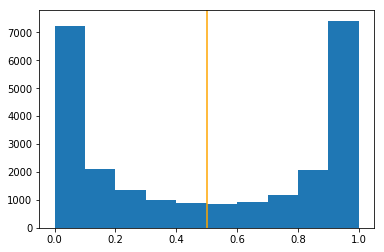

In [34]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [35]:
pct_auc = roc_auc_score(y_valid, y_hat) * 100

In [36]:
print('{:0.2f}'.format(pct_auc))
print(np.std(history.history['loss']))

93.55
0.1935140669005729


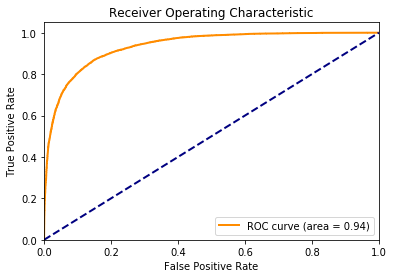

In [37]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_valid, y_hat)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

In [38]:
ydf = pd.DataFrame(list(zip(y_hat[:,0], y_valid)), columns=['y_hat', 'y'])
ydf.head(10)

,y_hat,y
0,0.627458,0
1,0.996518,1
2,0.526038,1
3,0.725809,0
4,0.985456,1
5,0.866497,1
6,0.547927,1
7,0.042084,0
8,0.919001,0
9,0.968091,1


In [39]:
' '.join(index_word[id] for id in all_X_valid[0])

"START please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

In [40]:
' '.join(index_word[id] for id in all_X_valid[6])

"START originally supposed to be just a part of a huge epic the year 1905 depicting the revolution of 1905 potemkin is the story of the mutiny of the crew of the potemkin in odessa harbor the film opens with the crew protesting meat and the captain ordering the execution of the an uprising takes place during which the revolutionary leader is killed this crewman is taken to the shore to lie in state when the townspeople gather on a huge flight of steps overlooking the harbor czarist troops appear and march down the steps breaking up the crowd a naval squadron is sent to retake the potemkin but at the moment when the ships come into range their crews allow the to pass through eisenstein's non historically accurate ending is open ended thus indicating that this was the seed of the later bolshevik revolution that would bloom in russia the film is broken into five parts men and maggots drama on the an appeal from the dead the odessa steps and meeting the squadron br br eisenstein was a revo

In [41]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
8,0.919001,0
66,0.939199,0
247,0.935801,0
256,0.911643,0
386,0.914342,0
740,0.945849,0
778,0.942027,0
781,0.913729,0
790,0.952708,0
814,0.926236,0


In [42]:
' '.join(index_word[id] for id in all_X_valid[112])

'START if you want to see a horror film which is horrible and in very bad taste this is definitely the film to view this films starts out with two young teenagers getting wild ideas about going into a chat room and going out on blind dates and quite possibly they will wind up like a little lamb to the slaughter house plenty of blood gore nudity handcuffs and all kinds of blood draining hooks and things you will never dream a person is capable of performing on men and women if you like piercing well this kind of piercing deals with heavy heavy hooks and plenty of besides lots of needles and thread to seal up things on the human body i really hope that this film does not give some sick person in this world the idea to act out these horrors in real life'

In [43]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
263,0.098701,1
300,0.086102,1
345,0.056282,1
440,0.084926,1
581,0.059815,1
595,0.080616,1
1113,0.059172,1
1261,0.077985,1
1627,0.036901,1
1911,0.072437,1


In [44]:
' '.join(index_word[id] for id in all_X_valid[101])

"START okul is the first of its kind in turkish cinema and it's way better than i expected those people who say it's neither scary nor funny have a point it's not all that great indeed but it must be kept in mind that everyone involved with the movie is rather amateur so it's basically a maiden voyage and comparing this one to other films such as the 1st class garbage propaganda this movie is pretty damn good br br one thing that must be said it deals with the highschool students' life in turkey very realistically that's exactly how it goes the scenes that are meant to scare are somewhat cheap and hollywoodish most of them even if not all but that religion lesson scene made me laugh in tears and performs the best acting of this flick as a religion teacher br br it's not a waste of your time go and watch it you'll find it rather amusing especially if you know turkey enough to relate to turkish school lives"

In [59]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

imdb_review = """This is a wolverine movie aimed at adults and definitely not for small children. The story is set in the future and Logan is taking care of Charles Xavier who has grown old and is incapable of taking care of himself. Logan, himself is now older and his health is slowly deteriorating as well. A young girl mutant enters their lives which sets off a story, which is not about super heroes fighting bad guys, but one that is on a more human level. "Logan", is a beautifully made X-Men film that deals with themes of importance of family, loyalty, and ultimately how Logan himself deals with new found emotions which he is experiencing for the very first time in his life.

This is the crowning achievement in Hugh Jackman's role as Wolverine. It is the movie he and director, James Mangold had always wanted to make. It is a dramatic work of art and for X-Men fans, has plenty of action and special FX which are a definite cut above anything that has been seen before in Wolverine/X-Men films.

A MUST SEE FOR ANY FAN AND A GOOD ENOUGH FILM TO STAND ALONE FOR ANYONE!!"""
review_tokens = word_tokenize(imdb_review)

In [69]:
review_index = [v if v <= 10000 else 3 for k,v in word_index.items() if k in review_tokens]
review_index = np.array([review_index], dtype='int32')
review_index.reshape((len(review_index[0])))

array([  69,   47,   19,   53,  125,  318,   31,   86,   65,   37,   29,
        113,  705,   17,  270,  233,   55,    9,   11,  493,   21,   23,
          7,  258,  154,  459, 1364,   73,  406, 6483, 3777,   27, 6387,
         93, 1116,   89, 3426,   58,  108, 5079, 1293,   24,  157, 1438,
          6,   78, 1165, 1326,  250,  476,   33,    3, 3603, 2033,  217,
        392,  150,  456,  159,  905,  605,  651, 3395,  167,   18,  206,
        210,  752,    4,  309, 1473,  162,   77,    5, 3365,  997,  732,
          3, 3579,    8,  185,  223,    3, 6606,  922,  110,   97,   22,
        656,   44,  958, 3711,   68,   63,   20,    3, 1737,   15,  407,
       2071,  498,   26,  473,  451], dtype=int32)

In [70]:
review_index.shape

(1, 104)

In [71]:
review_index = pad_sequences(review_index, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [72]:
review_index
review_index.shape

(1, 200)

In [73]:
y_hat = model.predict_proba(review_index)

In [74]:
y_hat

array([[0.9143832]], dtype=float32)